# Applying prophet to time series forecasting of Well and Riser flow rates

## Author: Ridha Alkhabaz

This is notebook to explore Prophet algorithm viability to predict mass flow rates in a off-shore riser. Specifically, we are investigating liquid mass flow rate in this notebook. 


## Imports:

In [1]:
import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot, dates
from prophet import Prophet
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
import datetime as dttm
os.chdir('/Users/ridhaalkhabaz/Documents/GitHub/VFM_ML/src')
from preprocessing import read_data_slugging
os.chdir('/Users/ridhaalkhabaz/Documents/GitHub/VFM_ML')
from main import model_init, model_train, model_predict 

Importing plotly failed. Interactive plots will not work.


#### Reading the data and visualization:

Our split here is to use the previous 10 periods to predict the last period. 

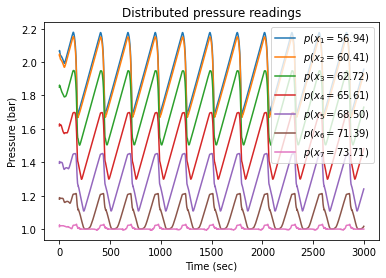

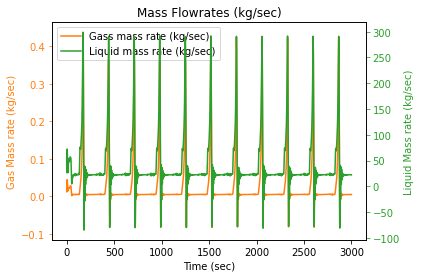

In [2]:
df,data_slugging,headers, _= read_data_slugging('riser_pq_uni.csv', plot_data=True)

In [3]:
### univariate prophet 
train_uni = pd.concat([df.iloc[:2806, 0], df.iloc[:2806, 8:]], axis=1)
test_uni = pd.concat([df.iloc[2806:, 0], df.iloc[2806:len(df), 8:]], axis=1)
### multivariate prophet 
train_mult = df.iloc[:2806]
test_mult = df.iloc[2806:len(df)]

#### Initialization:
We are trying to find the difference between univariate, multivairate, tuned and basic implementation of Prophet. 

In [5]:
prop_liq_uni_basic = model_init(model='Prophet', params=[], hyperparamters=[])
prop_liq_uni_tuned = model_init(model='Prophet', params=[], hyperparamters=[{'daily_seasonality':True,'holidays_prior_scale':0.01, 'seasonality_prior_scale':0.01,'changepoint_prior_scale':0.01, 'seasonality_mode':'additive'}], basic=False)
prop_liq_basic_mult = model_init(model='Prophet', params=['p1','p2','p3', 'p4', 'p5', 'p6', 'p7'], hyperparamters=[])
prop_liq_tuned_mult = model_init(model='Prophet', params=['p1','p2','p3', 'p4', 'p5', 'p6', 'p7'], hyperparamters=[{'daily_seasonality':True,'holidays_prior_scale':10.0, 'seasonality_prior_scale':0.01,'changepoint_prior_scale':0.1, 'seasonality_mode':'multiplicative'}], basic=False)

#### Curve-fitting:
we fit our data to our model.

In [6]:
trained_prop_liq_uni_basic = model_train(train_uni, 'liquid(kg/sec)', prop_liq_uni_basic, 'Prophet',[], [])
trained_prop_liq_uni_tuned = model_train(train_uni, 'liquid(kg/sec)', prop_liq_uni_tuned, 'Prophet',[], [])
trained_prop_liq_mult_basic = model_train(train_mult, 'liquid(kg/sec)', prop_liq_basic_mult, 'Prophet',[], [])
trained_prop_liq_mult_tuned = model_train(train_mult, 'liquid(kg/sec)', prop_liq_tuned_mult, 'Prophet',[], [])

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seas

#### Testing and visualization:
Here we use the testing data to find Prophet accuracy. 

In [10]:
prediction_data_liq_uni_basic, mse_liq_uni_basic = model_predict(test_uni, 'Prophet', trained_prop_liq_uni_basic, 'gas(kg/sec)')
prediction_data_liq_uni_basic['ds'] = range(2805, 3000)
prediction_data_liq_uni_tuned, mse_liq_uni_tuned = model_predict(test_uni, 'Prophet',trained_prop_liq_uni_tuned , 'gas(kg/sec)')
prediction_data_liq_uni_tuned['ds'] = range(2805, 3000)
prediction_data_liq_mult_basic, mse_liq_mult_basic = model_predict(test_mult, 'Prophet', trained_prop_liq_mult_basic, 'gas(kg/sec)')
prediction_data_liq_mult_basic['ds'] = range(2805, 3000)
prediction_data_liq_mult_tuned, mse_liq_mult_tuned = model_predict(test_mult, 'Prophet', trained_prop_liq_mult_tuned, 'gas(kg/sec)')
prediction_data_liq_mult_tuned['ds'] = range(2805, 3000)

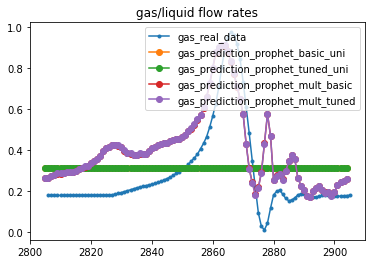

In [8]:
start_ploting = 0
end_ploting = 100
fig,ax = plt.subplots()
ax.set_title('gas/liquid flow rates')
ax.plot(test_mult['ds'].iloc[start_ploting:end_ploting], test_mult['gas(kg/sec)'].iloc[start_ploting:end_ploting], marker=".", label='gas_real_data')
ax.plot(prediction_data_liq_uni_basic['ds'].iloc[start_ploting:end_ploting], prediction_data_liq_uni_basic['yhat'].iloc[start_ploting:end_ploting], marker="o", label='gas_prediction_prophet_basic_uni')
ax.plot(prediction_data_liq_uni_tuned['ds'].iloc[start_ploting:end_ploting], prediction_data_liq_uni_tuned['yhat'].iloc[start_ploting:end_ploting], marker="o", label='gas_prediction_prophet_tuned_uni')
ax.plot(prediction_data_liq_mult_basic['ds'].iloc[start_ploting:end_ploting], prediction_data_liq_mult_basic['yhat'].iloc[start_ploting:end_ploting], marker="o", label='gas_prediction_prophet_mult_basic')
ax.plot(prediction_data_liq_mult_tuned['ds'].iloc[start_ploting:end_ploting], prediction_data_liq_mult_tuned['yhat'].iloc[start_ploting:end_ploting], marker="o", label='gas_prediction_prophet_mult_tuned')
ax.legend(loc='upper right')
fig.savefig('riser-prophet-results.jpeg')

In [11]:
mse_prophet_liq = pd.DataFrame(\
                               zip(['Prophet Univariate Basic', 'Prophet Univariate Tuned', 'Prophet Multivariate Basic', 'Prophet Multivariate Tuned'], \
                                   np.array([mse_liq_uni_basic,mse_liq_uni_tuned, mse_liq_mult_basic, mse_liq_mult_tuned]).T))
mse_prophet_liq

,0,1
0,Prophet Univariate Basic,0.032299
1,Prophet Univariate Tuned,0.032409
2,Prophet Multivariate Basic,0.016956
3,Prophet Multivariate Tuned,0.017063


## Appendix:
here we are going to tune the univariate model. 

In [13]:
import itertools
param_grid = {  
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'changepoint_prior_scale':[0.01, 0.1, 1.0],
    'seasonality_mode': ['multiplicative', 'additive']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

In [14]:
from prophet.diagnostics import cross_validation, performance_metrics
# Use cross validation to evaluate all parameters
liq_rmse = []
number_iter = 0
# run this for three different 
for params in all_params:
    trainSet_param = train_uni
    number_iter+=1
    trainSet_param = trainSet_param.rename(columns={'liquid(kg/sec)':'y'})
    m_liq = Prophet(**params).fit(trainSet_param)  
    df_cv_liq = cross_validation(m_liq,horizon='200 nano', initial='2100 nano', parallel="processes")
    df_p_liq = performance_metrics(df_cv_liq, rolling_window=3)
    liq_rmse.append(df_p_liq['rmse'].values[0])
    print(number_iter)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8810847e10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concu

1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881052bf50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881011dd90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


4


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881011dd90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881249b210>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88100ac050>


6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88117773d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


8


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8811748f90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


9


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8811748e50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88113ad490>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8810514d90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88120460d0>


12


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


13


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8810203450>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88113a2fd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


15


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88113a29d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


16


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88121438d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


17


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881214ea90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


18


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88113a2550>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


19


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881178c410>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


20


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8810503cd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


21


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881214e110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


22


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881011dd90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


23


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881178c410>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


24


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881174aa90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881214e990>


25


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


26


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881060f5d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


27


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881060cad0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


28


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8810514d90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


29


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8811748f90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


30


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8810843050>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881060f5d0>


31


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


32


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88113ad490>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


33


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8810843050>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


34


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8812046cd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


35


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881214ea90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


36


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8811748f90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


37


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881060ccd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


38


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8811618110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


39


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8811618110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


40


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881178c410>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


41


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f880fd04d50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


42


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8810847b90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881214ef90>


43


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


44


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8812046690>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


45


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88113a2fd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


46


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881214ea90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


47


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88124919d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


48


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88113ad490>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88113a29d0>


49


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


50


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88113ad490>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


51


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881214ef90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


52


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881213a4d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


53


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88113a2fd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


54


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88100ac050>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


55


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88113a2750>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


56


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8811748f90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


57


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88113fc590>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


58


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881213a4d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


59


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881249b110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


60


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881060cad0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


61


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881053d110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


62


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8812491dd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


63


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881060c510>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


64


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881249b110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


65


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88105036d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


66


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8810203450>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


67


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88120193d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


68


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88105f6c90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


69


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88113fc2d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


70


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881060f450>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


71


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88124713d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


72


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8812016550>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


73


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f880fd3c8d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


74


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88120d0110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


75


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8810203450>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


76


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881214ef90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


77


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88100ac050>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


78


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88125d3e10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


79


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88105033d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


80


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f880fd04910>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


81


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881035bad0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


82


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88113a2750>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


83


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88117776d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605


84


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f881011dd90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


85


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8810514d90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


86


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8810514d90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


87


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8810843050>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


88


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8812046b90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


89


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88105033d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


90


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88100ac050>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


91


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8810514950>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


92


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8810847e10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


93


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8810203450>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


94


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f880fd04910>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


95


INFO:prophet:Making 6 forecasts with cutoffs between 1970-01-01 00:00:00.000002105 and 1970-01-01 00:00:00.000002605
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f88113bcfd0>


96


In [16]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = liq_rmse
tuning_results[tuning_results['rmse'] < 0.135]

,seasonality_prior_scale,holidays_prior_scale,changepoint_prior_scale,seasonality_mode,rmse
0,0.01,0.01,0.01,multiplicative,0.134024
1,0.01,0.01,0.01,additive,0.134024
6,0.01,0.10,0.01,multiplicative,0.134024
7,0.01,0.10,0.01,additive,0.134024
12,0.01,1.00,0.01,multiplicative,0.134024
13,0.01,1.00,0.01,additive,0.134024
18,0.01,10.00,0.01,multiplicative,0.134024
19,0.01,10.00,0.01,additive,0.134024
24,0.10,0.01,0.01,multiplicative,0.134024
25,0.10,0.01,0.01,additive,0.134024
